In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [ ]:
%load_ext cudf.pandas
import argparse
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



We remove batch effect in different DRAGEN version

(BCs cohort is called variant by DRAGEN ver 4.2.6,

TWBs cohort is called variant by DRAGEN ver 4.0.3)



In [ ]:
#Load common SNPs with rsID variants from two batches
snplist_path = "/content/drive/MyDrive/PCA_by_two_datasets/miss_snp_in_different_bitch/filter_call_ratet_by_269_BC_and_748_TWB_in_geno02_mind02_geno02.lmiss.common.snplist"
snplist_df = pd.read_csv(snplist_path, header=None, sep='\t')
snplist = snplist_df[0].tolist()


In [ ]:
#load two batch missrate in each snps
BC_batch_path='/content/drive/MyDrive/PCA_by_two_datasets/miss_snp_in_different_bitch/filter_call_ratet_by_270_BC_in_geno02_mind02_geno02.lmiss'
BC_batch=pd.read_csv(BC_batch_path,sep='\s+')
TWB_batch_path='/content/drive/MyDrive/PCA_by_two_datasets/miss_snp_in_different_bitch/filter_call_ratet_by_748_TWB_in_geno02_mind02_geno02.lmiss'
TWB_batch=pd.read_csv(TWB_batch_path,sep='\s+')
TWB_batch.head()

In [ ]:
#Identify and common SNPs shared across different batches
TWB_batch_filtered=TWB_batch[TWB_batch['SNP'].isin(snplist)]
BC_batch_filtered=BC_batch[BC_batch['SNP'].isin(snplist)]

In [ ]:
#See the number of two batch having common SNPs
print(TWB_batch_filtered.shape)
print(BC_batch_filtered.shape)

In [ ]:
#We combined the SNP and F_MISS data from the two batches.
BC_and_TWB =pd.merge(TWB_batch_filtered[['SNP', 'F_MISS']],
           BC_batch_filtered[['SNP', 'F_MISS']],
            on='SNP',   suffixes=('_BC', '_TWB') )
BC_and_TWB.head()


In [ ]:
# Calculate the difference in the missingness frequency
BC_and_TWB['F_MISS.diff'] = BC_and_TWB['F_MISS_BC'] -BC_and_TWB['F_MISS_TWB']
BC_and_TWB.head()


In [ ]:
# plot different missing rate in two batch
fig, ax = plt.subplots(figsize=(7, 5))
clean_diffs = BC_and_TWB['F_MISS.diff'].dropna()
if not clean_diffs.empty:
    bins = int(np.ceil(clean_diffs.abs().max() / 0.0005)) if clean_diffs.abs().max() > 0 else 20
    n, bins, patches = ax.hist(clean_diffs,
                    bins=bins,
                    alpha=0.7, edgecolor="black",
                    weights=np.ones(len(clean_diffs)) / len(clean_diffs))

    # Color the bin containing 0 blue, others red
    for patch, bin_edge in zip(patches, bins):
        if bin_edge <= 0 < bins[np.where(bins == bin_edge)[0][0] + 1]:
            patch.set_facecolor('blue')
        else:
            patch.set_facecolor('red')

    ax.set_ylim(0,0.1)
    ax.set_xlabel("Variant Missing Rate Difference Between a Pair of Batches")
    ax.set_ylabel("Proportion of Variants")
    ax.set_title(f"Distribution of Missing Rate Difference in TWB vs. BC")
    fig.savefig("/content/drive/MyDrive/PCA_by_two_datasets/miss_snp_in_different_bitch/Distribution_of_Missing_Rate_Difference_in_TWB_vs_BC.png")

In [ ]:
#Find different of two batch missing rate >0.001
TWB_and_BC_differ=BC_and_TWB[['SNP','F_MISS.diff']]
TWB_and_BC_differ=TWB_and_BC_differ.dropna(how='any',axis=0)
TWB_and_BC_differ=TWB_and_BC_differ[(TWB_and_BC_differ['F_MISS.diff'] > 0.001) |
                  (TWB_and_BC_differ['F_MISS.diff'] < -0.001)  ]
TWB_and_BC_differ['SNP'].to_csv("/content/drive/MyDrive/PCA_by_two_datasets/miss_snp_in_different_bitch/TWB_and_BC_overall_missRateDiff_0.001.snplist"
,index=False,header=False)


In [ ]:
batch_diffs=BC_and_TWB[BC_and_TWB['F_MISS.diff'] !=0 ]
print(f'The number of different missing rate varint: {len(batch_diffs)} ')
batch_ratio=(len(batch_diffs)/len(TWB_batch_filtered['F_MISS']))
print(f'The batch ratio in TWB or BC batch: {batch_ratio:.4f}' )

We draw PCA by TWB female and 269 BC merge 1000G samples (DRAGEN ver 4.2.7) to genetic ancestry anylsis




In [ ]:
#load pca file
pca = pd.read_table('/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/Our_data_merge_1000G_dragen/TWB_merge_269_BC_in_1000G.pca.eigenvec',sep="\t")
print(pca.head())

#load 1000G fam file
fam_data = pd.read_table('/content/drive/MyDrive/PCA_by_two_datasets/all_hg38.psam',sep="\t")
fam_data.head()

#merge two dataset by pd.merge
eigenvec_data = pd.merge(pca, fam_data,right_on="#IID",left_on="IID",how="outer")
eigenvec_data['SuperPop'] = eigenvec_data['SuperPop'].fillna('Our cohort')
eigenvec_data.tail()
sample_number=eigenvec_data.shape[0]
print(sample_number)
#plot pca
plt.figure(figsize=(15,15))
# Capture the AxesSubplot object returned by sns.scatterplot
sns.scatterplot(eigenvec_data,x=eigenvec_data['PC1'],y=eigenvec_data['PC2'],hue=eigenvec_data['SuperPop'],s=50)
ax = plt.gca()
legend = ax.get_legend()
plt.setp(legend.get_texts(), fontsize='20')
plt.setp(legend.get_title(), fontsize='20')
plt.xlabel("PC1",fontsize=25)
plt.ylabel("PC2",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/Our_data_merge_1000G_dragen/PCA_result_in_TWB_female_and_269_BC_merge_1000G_samples.png")
plt.close()


  FID      IID       PC1       PC2       PC3       PC4       PC5       PC6  \
0   0  HG00096  0.001321  0.025575 -0.003732  0.020397  0.000602  0.003366   
1   0  HG00097  0.001577  0.025493 -0.004059  0.019861 -0.000182  0.001941   
2   0  HG00099  0.001197  0.025879 -0.004675  0.019235  0.002297  0.003018   
3   0  HG00100  0.001470  0.025838 -0.003362  0.019987  0.001432  0.004090   
4   0  HG00101  0.001197  0.025301 -0.004387  0.019947 -0.001418  0.003798   

        PC7       PC8  ...      PC11      PC12      PC13      PC14      PC15  \
0  0.017804 -0.008088  ... -0.002695 -0.005340  0.004005 -0.004646 -0.000217   
1  0.016086 -0.003081  ...  0.003243 -0.007475  0.000271 -0.003980  0.001566   
2  0.021619 -0.001188  ... -0.002729 -0.002432  0.002715  0.001441  0.010642   
3  0.010480  0.000222  ... -0.003252 -0.005434 -0.000887 -0.005685  0.002457   
4  0.020373 -0.000954  ... -0.001457 -0.001249  0.001767 -0.005055  0.002489   

       PC16      PC17      PC18      PC19      PC2

We performed PCA using our cohorts to identify East Asian population structure.

In [ ]:
#load our pca file
pca = pd.read_table('/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/Our_data_merge_1000G_dragen/TWB_merge_269_BC_in_1000G.pca.eigenvec',sep="\t")
print(pca.head())
#load 1000G fam file
fam_data = pd.read_table('/content/drive/MyDrive/PCA_by_two_datasets/all_hg38.psam',sep="\t")
eigenvec_data = pd.merge(pca, fam_data,right_on="#IID",left_on="IID",how="outer")
eigenvec_data['SuperPop'] = eigenvec_data['SuperPop'].fillna('Our cohort')
eigenvec_data_in_Asia=eigenvec_data[eigenvec_data['SuperPop']=='EAS']
eigenvec_data_in_Our_cohort=eigenvec_data[eigenvec_data['SuperPop']=='Our cohort']
eigenvec_data_in_our_by_Asia=pd.concat([eigenvec_data_in_Asia,eigenvec_data_in_Our_cohort])
eigenvec_data_in_our_by_Asia['Population']=eigenvec_data_in_our_by_Asia['Population'].fillna('Our cohort')
eigenvec_data_in_our_by_Asia
#plot pca
plt.figure(figsize=(15,15))
sns.scatterplot(eigenvec_data_in_our_by_Asia,
        x=eigenvec_data_in_our_by_Asia['PC1'],
        y=eigenvec_data_in_our_by_Asia['PC2'],
        hue=eigenvec_data_in_our_by_Asia['Population'],s=50)
ax = plt.gca()
legend = ax.get_legend()
plt.setp(legend.get_texts(), fontsize='20')
plt.setp(legend.get_title(), fontsize='20')
plt.xlabel("PC1",fontsize=25)
plt.ylabel("PC2",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/Our_data_merge_1000G_dragen/PCA_result_in_TWB_female_and_269_BC_merge_1000G_by_Asia.png")
plt.close()


  FID      IID       PC1       PC2       PC3       PC4       PC5       PC6  \
0   0  HG00096  0.001321  0.025575 -0.003732  0.020397  0.000602  0.003366   
1   0  HG00097  0.001577  0.025493 -0.004059  0.019861 -0.000182  0.001941   
2   0  HG00099  0.001197  0.025879 -0.004675  0.019235  0.002297  0.003018   
3   0  HG00100  0.001470  0.025838 -0.003362  0.019987  0.001432  0.004090   
4   0  HG00101  0.001197  0.025301 -0.004387  0.019947 -0.001418  0.003798   

        PC7       PC8  ...      PC11      PC12      PC13      PC14      PC15  \
0  0.017804 -0.008088  ... -0.002695 -0.005340  0.004005 -0.004646 -0.000217   
1  0.016086 -0.003081  ...  0.003243 -0.007475  0.000271 -0.003980  0.001566   
2  0.021619 -0.001188  ... -0.002729 -0.002432  0.002715  0.001441  0.010642   
3  0.010480  0.000222  ... -0.003252 -0.005434 -0.000887 -0.005685  0.002457   
4  0.020373 -0.000954  ... -0.001457 -0.001249  0.001767 -0.005055  0.002489   

       PC16      PC17      PC18      PC19      PC2

In [ ]:
eigenvec_data_in_Asia.head()
eigenvec_data_in_Asia_id=eigenvec_data_in_Asia[['FID','IID']]
eigenvec_data_in_Asia_id.to_csv("/content/drive/MyDrive/PCA_by_two_datasets/1000G_in_EAS_sample.list",index=False)

We draw PCA by TWB female and 269 BC samples

In [ ]:
#load pca file
pca = pd.read_table('/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/748_TWB_and_269_BCs/TWB_merge_269_BC_in_geno02_mind02.pca.eigenvec',sep='\t')
#plot pca
plt.figure(figsize=(10,10))
pca['Group'] = pca['FID'].apply(
    lambda x: 'BC' if 'BC' in x else 'TWB')
sns.scatterplot(pca,x=pca['PC1'],y=pca['PC2'],hue=pca['Group'],s=50)
ax = plt.gca()
legend = ax.get_legend()
plt.setp(legend.get_texts(), fontsize='16')
plt.setp(legend.get_title(), fontsize='16')
plt.xlabel("PC1",fontsize='20')
plt.ylabel("PC2",fontsize='20')
plt.xlim(-0.075, 0.075)
plt.ylim(-0.05, 0.05)
plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/748_TWB_and_269_BCs/PCA_result_in_TWB_and_269_BC_samples.png")
plt.close()


We draw PCA by TWB female and 269 BC samples  
(Remove bais effect of difference miss rate in two cohorts  )

In [ ]:
#load pca file
pca = pd.read_table('/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/748_TWB_and_269_BCs/TWB_merge_269_BC_in_qc_finlish.pca.eigenvec',sep='\t')
#plot pca
plt.figure(figsize=(10,10))
pca['Group'] = pca['FID'].apply(
    lambda x: 'BC' if 'BC' in x else 'TWB')
sns.scatterplot(pca,x=pca['PC1'],y=pca['PC2'],hue=pca['Group'],s=50)
ax = plt.gca()
legend = ax.get_legend()
plt.setp(legend.get_texts(), fontsize='16')
plt.setp(legend.get_title(), fontsize='16')
plt.xlabel("PC1",fontsize='20')
plt.ylabel("PC2",fontsize='20')
plt.xlim(-0.075, 0.075)
plt.ylim(-0.05, 0.05)
plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/PCA_result/748_TWB_and_269_BCs/PCA_result_in_TWB_and_269_BC_samples_by_remove_bias_difference.png")
plt.close()


Plot het rate distribution and filter +/- 6 SD in TWB and 269 BC samples


In [ ]:
# Read in het data
het_path='/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/TWB_merge_269_BC_in_qc_finlish-ldpr.het'
het = pd.read_csv(het_path ,sep='\s+')
# Plot F-stat distribution
plt.figure(figsize=(7, 4))
plt.hist(het['F'], bins=100, alpha=0.6, color="black", edgecolor='black', linewidth=0.5)  # Adjust bins as needed
plt.xlabel("Inbreeding coefficient (F-stat)")
plt.ylabel("Frequency")
plt.title("Sample QC by TWB and 269 BC")
plt.axvline(x=-0.2, linestyle="dashed", color='gray')
plt.axvline(x=0.2, linestyle="dashed", color='gray')
plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/TWB_merge_266_BC_fstat_thresh02.pdf")
plt.close()

# Plot heterozygosity rate distribution
cutoff1 = [het['F'].mean() - 3 * het['F'].std(), het['F'].mean() + 3 * het['F'].std()]
cutoff2 = [het['F'].mean() - 6 * het['F'].std(), het['F'].mean() + 6 * het['F'].std()]

plt.figure(figsize=(7, 4))
plt.hist(het['F'], bins=100, alpha=0.6, color="black", edgecolor='black', linewidth=0.5)  # Adjust bins as needed
plt.xlabel("Heterozygosity rate")
plt.ylabel("Frequency")
plt.title(f"Sample QC by TWB and 269 BC")
plt.axvline(x=cutoff1[0], linestyle="dashed", color='gray')
plt.axvline(x=cutoff1[1], linestyle="dashed", color='gray')
plt.axvline(x=cutoff2[0], linestyle="dashed", color='gray')
plt.axvline(x=cutoff2[1], linestyle="dashed", color='gray')
# Annotate lines (adjust positions as needed)
plt.text(cutoff1[0], 4000, "mean - 3SD", rotation=90, va='center', ha='right', fontsize=8)
plt.text(cutoff1[1], 4000, "mean + 3SD", rotation=90, va='center', ha='right', fontsize=8)
plt.text(cutoff2[0], 4000, "mean - 6SD", rotation=90, va='center', ha='right', fontsize=8)
plt.text(cutoff2[1], 4000, "mean + 6SD", rotation=90, va='center', ha='right', fontsize=8)

plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/TWB_merge_266_BC_hetcheck_hetrate_dev_from_mean.pdf")
plt.close()

# Write out lists of outlier samples
het_fstat_outliers = het[(het['F'] < -0.2) | (het['F'] > 0.2)][['FID', 'IID']]
het_fstat_outliers.to_csv("/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/TWB_merge_266_BC_het_outlier_f02.indlist", sep="\t", index=False, header=False)

hetrate_cutoff1_outliers = het[(het['F'] < cutoff1[0]) | (het['F'] > cutoff1[1])][['FID', 'IID']]
hetrate_cutoff1_outliers.to_csv("/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/TWB_merge_266_BC_het_outlier_3sd.indlist", sep="\t", index=False, header=False)

hetrate_cutoff2_outliers = het[(het['F'] < cutoff2[0]) | (het['F'] > cutoff2[1])][['FID', 'IID']]
hetrate_cutoff2_outliers.to_csv("/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/TWB_merge_266_BC_het_outlier_6sd.indlist", sep="\t", index=False, header=False)

Plot IBD to infer relatedness and extract one from each pair of related's (pihat>0.2) for removal in TWB and 269 BC samples

inferred_rel
Duplicates/MZ-twins    2
Siblings               1
Parent-offspring       0
Other relatedness      0
Unrelated              0
Name: count, dtype: int64


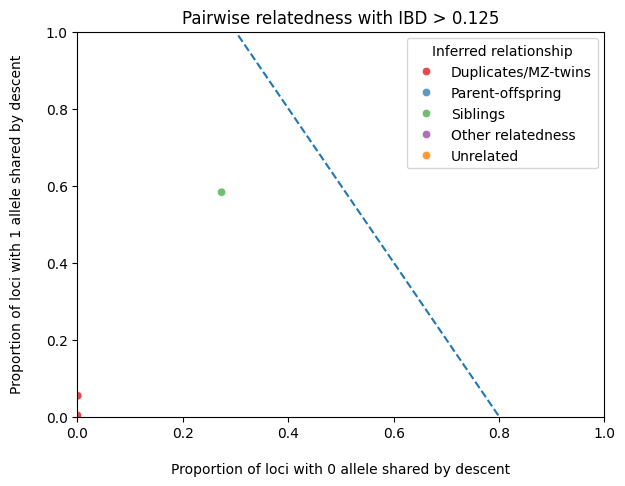

(3, 15)
1
2
3
3
3
(6, 2)


In [ ]:
# Read in IBD data
ibd_path='/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/TWB_merge_269_BC_in_qc_finlish-ibd-min0.125.genome'
ibd = pd.read_csv(ibd_path, sep="\s+")
# Plot relatedness among pop-specific samples: Z0 vs. Z1 by inferred relationship
ibd['inferred_rel'] = "Other relatedness"
ibd.loc[ibd['PI_HAT'] <= 0.2, 'inferred_rel'] = "Unrelated"
ibd.loc[(ibd['Z0'] < 0.1) & (ibd['Z1'] < 0.1), 'inferred_rel'] = "Duplicates/MZ-twins"
ibd.loc[(ibd['Z0'] < 0.1) & (ibd['Z1'] > 0.9), 'inferred_rel'] = "Parent-offspring"
ibd.loc[(ibd['Z0'] > 0.125) & (ibd['Z0'] < 0.375), 'inferred_rel'] = "Siblings"

ibd['inferred_rel'] = pd.Categorical(ibd['inferred_rel'],
                                   categories=["Duplicates/MZ-twins",
                                               "Parent-offspring",
                                               "Siblings",
                                               "Other relatedness",
                                               "Unrelated"])

print(ibd['inferred_rel'].value_counts())

thresh = 0.2
plt.figure(figsize=(6.8, 5))
sns.scatterplot(x='Z0', y='Z1', hue='inferred_rel', data=ibd, alpha=0.8, palette="Set1")
plt.plot([0, 1], [2 - 2*thresh, -2*thresh], linestyle='dashed')
plt.xlabel("\nProportion of loci with 0 allele shared by descent")
plt.ylabel("Proportion of loci with 1 allele shared by descent\n")
plt.title("Pairwise relatedness with IBD > 0.125")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(title="Inferred relationship")
plt.savefig(f"/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/Filter_IBD_TWB_merge_269_BC_ibd_Z0.vs.Z1.pdf")
plt.show()

# Remove one from each pair of related individuals
ibd_rel = ibd[ibd['PI_HAT'] > 0.2]
print(ibd_rel.shape)

samples = ibd_rel[['IID1', 'IID2']].stack().value_counts().index.tolist()
removed = []

k = 0
for row in ibd_rel.itertuples():
    i_sample = row.IID1
    j_sample = row.IID2

    try:
        i_index = samples.index(i_sample)
        j_index = samples.index(j_sample)
    except ValueError:
        continue

    if i_index <= j_index:
        removed.append(i_sample)
        samples.remove(i_sample)
    else:
        removed.append(j_sample)
        samples.remove(j_sample)

    k += 1
    print(k)

print(len(removed))
print(len(samples))


# Merge IID with FID for export
tmp1 = ibd_rel[['FID1', 'IID1']].copy()
tmp1.columns = ['FID', 'IID']
tmp2 = ibd_rel[['FID2', 'IID2']].copy()
tmp2.columns = ['FID', 'IID']
ibd_rel_inds = pd.concat([tmp1, tmp2]).drop_duplicates()
print(ibd_rel_inds.shape)
ibd_rel_inds_remove = ibd_rel_inds[ibd_rel_inds['IID'].isin(removed)]

# Write out a list of relatedness individuals for removal
ibd_rel_inds_remove[['FID', 'IID']].to_csv(f"/content/drive/MyDrive/PCA_by_two_datasets/het_and_IBD/269_BC_and_748_TWB/IBD_TWB_merge_269_BC_ibd_pihat02.indlist",
                                          sep="\t", index=False, header=False)

GWAS results were obtained by applying the F-test to our dataset by python code


In [ ]:
F_test_path="/content/drive/MyDrive/PCA_by_two_datasets/GWAS_data/TWB_merge_BC_without_BCRA_pass_filtered.assoc.fisher"
F_test=pd.read_table(F_test_path,sep="\s+")
F_test=F_test.dropna(how="any",axis=0)
F_test['Chr:BP']=F_test['CHR'].astype(str)+':'+F_test['BP'].astype(str)
F_test.head()

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,Chr:BP
0,1,1:610809,610809,T,0.002016,0.002033,A,1.0000,0.9919,1:610809
1,1,1:629885,629885,G,0.008075,0.008000,A,1.0000,1.0090,1:629885
2,1,1:777334,777334,C,0.002008,0.002000,A,1.0000,1.0040,1:777334
3,1,1:777491,777491,C,0.026770,0.022000,T,0.6266,1.2230,1:777491
4,1,1:777996,777996,G,0.003347,0.004000,C,1.0000,0.8361,1:777996


In [ ]:
running_pos = 0

cumulative_pos = []

for chrom, group_df in F_test.groupby('CHR'):
    cumulative_pos.append(group_df['BP'] + running_pos)
    running_pos += group_df['BP'].max()
F_test['-log10p']=-np.log10(F_test['P'])
F_test['cumulative_pos'] = pd.concat(cumulative_pos)
F_test['SNP number'] = F_test.index
F_test

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,Chr:BP,-log10p,cumulative_pos,SNP number
0,1,1:610809,610809,T,0.002016,0.002033,A,1.0000,0.9919,1:610809,-0.000000,610809,0
1,1,1:629885,629885,G,0.008075,0.008000,A,1.0000,1.0090,1:629885,-0.000000,629885,1
2,1,1:777334,777334,C,0.002008,0.002000,A,1.0000,1.0040,1:777334,-0.000000,777334,2
3,1,1:777491,777491,C,0.026770,0.022000,T,0.6266,1.2230,1:777491,0.203010,777491,3
4,1,1:777996,777996,G,0.003347,0.004000,C,1.0000,0.8361,1:777996,-0.000000,777996,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7641892,22,22:50791658,50791658,T,0.005355,0.002000,A,0.4646,2.6860,22:50791658,0.332921,2871551971,7641892
7641893,22,22:50792111,50792111,G,0.000669,0.004000,A,0.1570,0.1668,22:50792111,0.804100,2871552424,7641893
7641894,22,22:50792792,50792792,G,0.044850,0.038000,A,0.6111,1.1890,22:50792792,0.213888,2871553105,7641894
7641895,22,22:50793134,50793134,A,0.151500,0.164700,C,0.4752,0.9056,22:50793134,0.323124,2871553447,7641895


Text(0.5, 0.98, 'GWAS plot by F test in Our data')

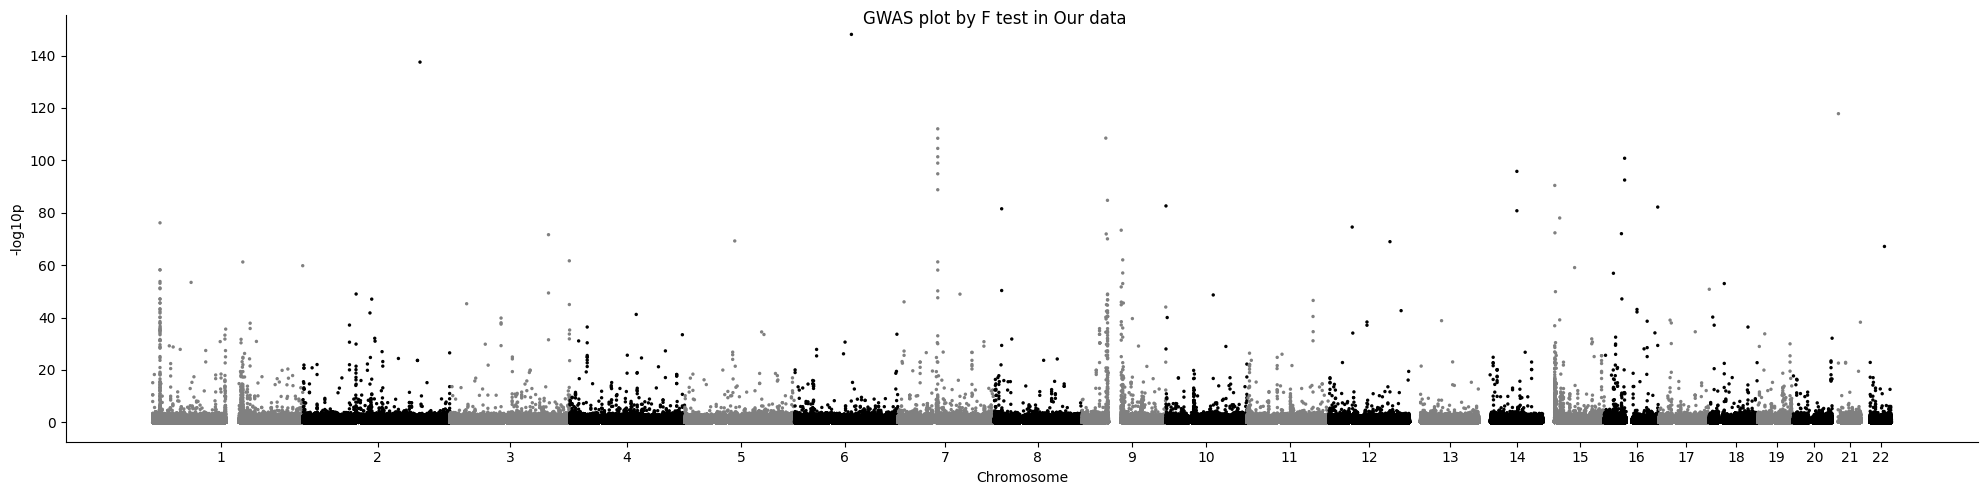

In [ ]:
g = sns.relplot(
    data = F_test,
    x = 'cumulative_pos',
    y = '-log10p',
    aspect = 4,
    hue = 'CHR',
    palette = ['grey', 'black'] * 11,
    linewidth = 0,
    s=6,
    legend=None
)

g.ax.set_xlabel('Chromosome')

g.ax.set_xticks(F_test.groupby('CHR')['cumulative_pos'].median())

g.ax.set_xticklabels(F_test['CHR'].unique())

g.fig.suptitle('GWAS plot by F test in Our data')


In [ ]:
!pip install qmplot

  Preparing metadata (setup.py) ... done
  Created wheel for qmplot: filename=qmplot-0.3.3-py3-none-any.whl size=25597 sha256=f5b9adfe8196c61dc69cb04af3b4a4c7018c572a81e893a2877e78447b175f9d
  Stored in directory: /root/.cache/pip/wheels/cf/fe/22/fc8b635bf0439d21e89000d0f0d2443982f7555655eab7dd06
Successfully built qmplot


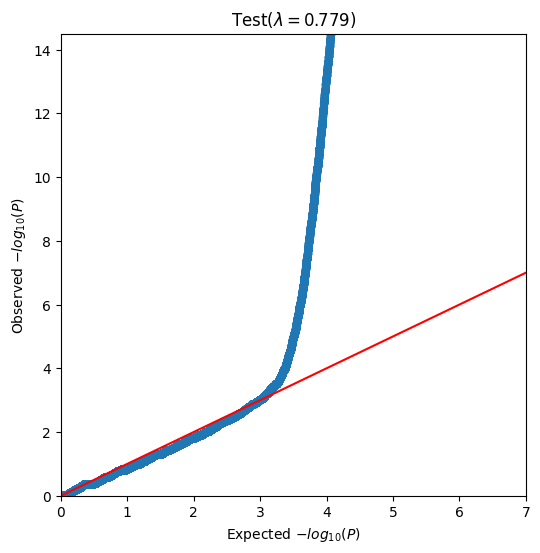

In [ ]:
from qmplot import qqplot

if __name__ == "__main__":
    files = pd.read_table(F_test_path, sep="\s+")
    files = files.dropna(how="any", axis=0)  # clean data

    # Create a Q-Q plot
    f, ax = plt.subplots(figsize=(6, 6), facecolor="w", edgecolor="k")
    qqplot(data=files["P"],
           marker="o",
           title="Test",
           xlabel=r"Expected $-log_{10}{(P)}$",
           ylabel=r"Observed $-log_{10}{(P)}$",
           ax=ax)
    ax.set_ylim(0, 14.5)
    ax.set_xlim(0, 7)

    plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/GWAS_data/test.QQ.png")


In [ ]:
#Find 7 significance gene in both BioBank Japan (BBJ) and our cohort  by F-test
F_test_ASTN2=F_test[F_test['Chr:BP']=='9:117069695']
F_test_ASTN2
F_test_RAD51B=F_test[F_test['Chr:BP']=='14:68115108']
F_test_RAD51B
F_test_FTO=F_test[F_test['Chr:BP']=='16:54046736']
F_test_FTO
F_test_PCNT=F_test[F_test['Chr:BP']=='21:46403758']
F_test_PCNT
F_test_PRKG1=F_test[F_test['Chr:BP']=='10:52182315']
F_test_PRKG1
F_test_RNF115=F_test[F_test['Chr:BP']=='1:145812072']
F_test_RNF115
F_test_HLA_B=F_test[F_test['Chr:BP']=='6:31302953']
F_test_HLA_B


,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,Chr:BP
2989728,6,6:31302953,31302953,A,0.01745,0.11,G,1.382000e-16,0.1437,6:31302953


In [ ]:
#Find DLGAP2 in both CMU and our cohort by F-test
F_test_DLGAP2=F_test[F_test['Chr:BP']=='8:1626226']
F_test_DLGAP2

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,Chr:BP
3845395,8,8:1626226,1626226,C,0.000669,0.05823,T,4.278000e-17,0.01083,8:1626226


In [ ]:
#Find novel singuture use FUMA in our cohort by F-test
F_test_LOC101927691=F_test[F_test['Chr:BP']=='6:867949']
F_test_LOC101927691
F_test_LINC01388=F_test[F_test['Chr:BP']=='9:114249']
F_test_LINC01388
F_test_LOC105373324=F_test[F_test['Chr:BP']=='2:179092']
F_test_LOC105373324

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,Chr:BP,-log10p,cumulative_pos,SNP number
620156,2,2:179092,179092,T,0.002016,0.038,C,2.194000e-09,0.05114,2:179092,8.658763,249110433,620156


In [ ]:
#Find novel singuture in our cohort by F-test
F_test_LINC02253=F_test[F_test['Chr:BP']=='15:97416152']
F_test_LINC02253
F_test_DHRS4=F_test[F_test['Chr:BP']=='14:23958213']
F_test_DHRS4
F_test_GOLGA8IP=F_test[F_test['Chr:BP']=='15:22601697']
F_test_GOLGA8IP
F_test_SS18L1=F_test[F_test['Chr:BP']=='20:62166719']
F_test_SS18L1
F_test_NOTCH2=F_test[F_test['Chr:BP']=='1:120028325']
F_test_NOTCH2
F_test_HYDIN2=F_test[F_test['Chr:BP']=='1:146616317']
F_test_HYDIN2
F_test_ZNF160=F_test[F_test['Chr:BP']=='19:53099079']
F_test_ZNF160
F_test_PRAMEF2=F_test[F_test['Chr:BP']=='1:12861596']
F_test_PRAMEF2
F_test_CYP2F1=F_test[F_test['Chr:BP']=='19:41121497']
F_test_CYP2F1
F_test_VIRMA=F_test[F_test['Chr:BP']=='8:94491119']
F_test_VIRMA

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR,Chr:BP
4104964,8,8:94491119,94491119,T,0.1237,0.268,G,3.122000e-13,0.3854,8:94491119


GWAS results were obtained by applying GCTA LOCO module to our dataset by python code

In [ ]:
files=pd.read_table("/content/drive/MyDrive/PCA_by_two_datasets/GWAS_data/TWB_merge_BC_without_BCRA_pass_filtered_QC_LOCO.loco.mlma",sep="\s+")
files=files.dropna(how="any",axis=0)
files['Chr:BP']=files['Chr'].astype(str)+':'+files['bp'].astype(str)
files.head()

,Chr,SNP,bp,A1,A2,Freq,b,se,p,Chr:BP
0,1,1:777491,777491,C,T,0.025577,0.024206,0.058413,0.678592,1:777491
1,1,1:778639,778639,G,A,0.023139,0.086473,0.061367,0.158807,1:778639
2,1,1:779242,779242,C,G,0.023594,0.049146,0.060791,0.418836,1:779242
3,1,1:779356,779356,G,A,0.021565,0.099950,0.063485,0.115397,1:779356
4,1,1:779760,779760,C,G,0.024072,0.010831,0.060152,0.857108,1:779760


In [ ]:
running_pos = 0

cumulative_pos = []

for chrom, group_df in files.groupby('Chr'):
    cumulative_pos.append(group_df['bp'] + running_pos)
    running_pos += group_df['bp'].max()
files['-log10p']=-np.log10(files['p'])
files['cumulative_pos'] = pd.concat(cumulative_pos)
files['SNP number'] = files.index
files

NameError: name 'files' is not defined

In [ ]:
#Search P < 1 × 10−100 ,P < 1 × 10−20 ,P < 5 × 10-8
files_log_100=files[files['p']<1e-100]
files_log_100.shape
files_log_20=files[(files['p']<1e-20) & (files['p']>=1e-100)]
files_log_20.shape
files_log_8=files[(files['p']<5e-8) & (files['p']>=1e-20)]
files_log_8.shape

(1000, 13)

Text(0.5, 0.98, 'GWAS plot by GCTA  GCTA-LOCO in Our data')

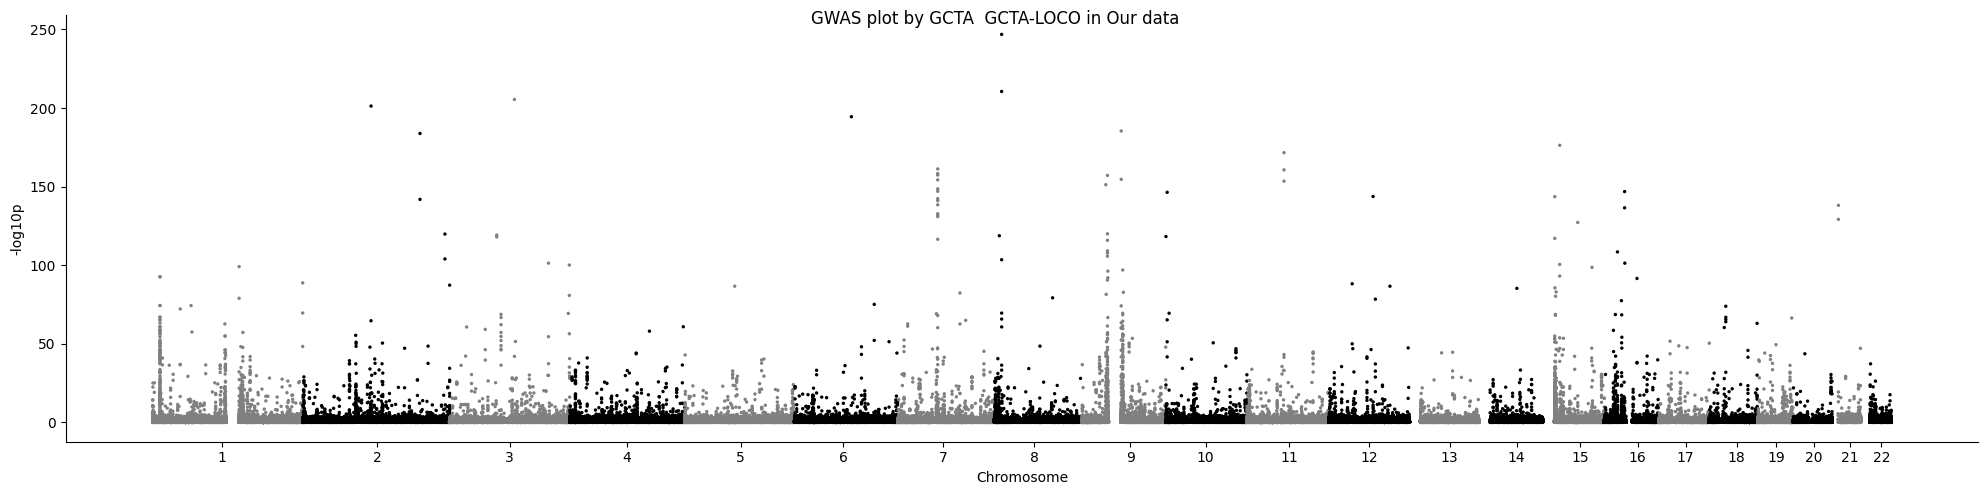

In [ ]:
g = sns.relplot(
    data = files,
    x = 'cumulative_pos',
    y = '-log10p',
    aspect = 4,
    hue = 'Chr',
    palette = ['grey', 'black'] * 11,
    linewidth = 0,
    s=6,
    legend=None
)

g.ax.set_xlabel('Chromosome')

g.ax.set_xticks(files.groupby('Chr')['cumulative_pos'].median())

g.ax.set_xticklabels(files['Chr'].unique())

g.fig.suptitle('GWAS plot by GCTA  GCTA-LOCO in Our data')

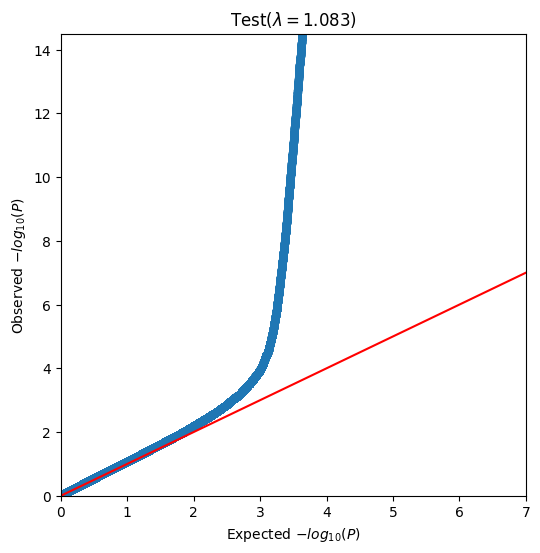

In [ ]:
from qmplot import qqplot

if __name__ == "__main__":

    # Create a Q-Q plot
    f, ax = plt.subplots(figsize=(6, 6), facecolor="w", edgecolor="k")
    qqplot(data=files["p"],
           marker="o",
           title="Test",
           xlabel=r"Expected $-log_{10}{(P)}$",
           ylabel=r"Observed $-log_{10}{(P)}$",
           ax=ax)
    ax.set_ylim(0, 14.5)
    ax.set_xlim(0, 7)

    plt.savefig("/content/drive/MyDrive/PCA_by_two_datasets/GCTA-LOCO.QQ.png")

In [ ]:
#Fing 10 significance level in both  BioBank Japan (BBJ) cohort by GCTA
files_ASTN2=files[files['Chr:BP']=='9:117069695']
files_ASTN2
files_RAD51B=files[files['Chr:BP']=='14:68115108']
files_RAD51B
files_FTO=files[files['Chr:BP']=='16:54046736']
files_FTO
files_PCNT=files[files['Chr:BP']=='21:46403758']
files_PCNT
files_PRKG1=files[files['Chr:BP']=='10:52182315']
files_PRKG1
files_RNF115=files[files['Chr:BP']=='1:145812072']
files_RNF115
files_HLA_B=files[files['Chr:BP']=='6:31302953']
files_HLA_B

,Chr,SNP,bp,A1,A2,Freq,b,se,p,Chr:BP
1440543,6,6:31302953,31302953,A,G,0.040703,-0.323598,0.040574,1.517360e-15,6:31302953


In [ ]:
#Fing DLGAP2 in both CMU and our cohort by GCTA
files_DLGAP2=files[files['Chr:BP']=='8:1626226']
files_DLGAP2

,Chr,SNP,bp,A1,A2,Freq,b,se,p,Chr:BP
1862027,8,8:1626226,1626226,C,T,0.01506,-0.705925,0.073792,1.106320e-21,8:1626226


In [ ]:
#Find novel singuture in our cohort by GCTA

files_LINC01388=files[files['Chr:BP']=='9:114249']
files_LINC01388
files_LOC101927691=files[files['Chr:BP']=='6:867949']
files_LOC101927691
files_LOC105373324=files[files['Chr:BP']=='2:179092']
files_LOC105373324

,Chr,SNP,bp,A1,A2,Freq,b,se,p,Chr:BP
298229,2,2:179092,179092,T,C,0.011066,-0.54814,0.083183,4.411420e-11,2:179092


In [ ]:
#Find novel singuture in our cohort by GCTA
files_LINC02253=files[files['Chr:BP']=='15:97416152']
files_LINC02253
files_DHRS4=files[files['Chr:BP']=='14:23958213']
files_DHRS4
files_GOLGA8IP=files[files['Chr:BP']=='15:22601697']
files_GOLGA8IP
files_SS18L1=files[files['Chr:BP']=='20:62166719']
files_SS18L1
files_NOTCH2=files[files['Chr:BP']=='1:120028325']
files_NOTCH2
files_HYDIN2=files[files['Chr:BP']=='1:146616317']
files_HYDIN2
files_ZNF160=files[files['Chr:BP']=='19:53099079']
files_ZNF160
files_PRAMEF2=files[files['Chr:BP']=='1:12861091']
files_PRAMEF2
files_CYP2F1=files[files['Chr:BP']=='19:41121497']
files_CYP2F1
files_VIRMA=files[files['Chr:BP']=='8:94491119']
files_VIRMA
#

,Chr,SNP,bp,A1,A2,Freq,b,se,p,Chr:BP
1983928,8,8:94491119,94491119,T,G,0.15996,-0.159483,0.022235,7.365550e-13,8:94491119
